In [13]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, auc, RocCurveDisplay,  silhouette_score, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


## 1. data load

In [14]:
df = pd.read_csv("/Users/yj.noh/Desktop/on_boarding_data.csv", encoding = "cp949")
print(df.isna().sum())

brms_rider_id           0
birth                   0
delivery_method         0
insurance_type          0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
active_days             0
avg_daily_delivery      0
avg_distance            0
avg_fee                 0
last_working_day        0
outcome                 0
dtype: int64


In [15]:
#data_filter = df[((df['day_cnt'].notnull()) & (df['delivery_method'] == 'BIKE') & (df['is_recom'] == 0))]
data_filter = df[((df['active_days'].notnull()) & (df['delivery_method'] == 'BIKE'))]
#data_filter =  df[df['day_cnt'].notnull()]   

print(data_filter.isna().sum())
print(data_filter.shape) # 7,940

brms_rider_id           0
birth                   0
delivery_method         0
insurance_type          0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
active_days             0
avg_daily_delivery      0
avg_distance            0
avg_fee                 0
last_working_day        0
outcome                 0
dtype: int64
(3429, 14)


In [16]:
# 1 - 미이탈, 0 - 이탈 
mapping = {0 : 1, 1 : 0}
data_filter['outcome'] = data_filter['outcome'].replace(mapping)

In [17]:
print(data_filter['outcome'].value_counts()) # 2,243, 1,186

outcome
1    2243
0    1186
Name: count, dtype: int64


In [18]:
# outlier 제거 
def remove_outliers(df, column):
    Q1 = df.groupby('outcome')[column].quantile(0.25)
    Q3 = df.groupby('outcome')[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[df.apply(lambda x: (x[column] >= lower_bound[x['outcome']]) & 
                                 (x[column] <= upper_bound[x['outcome']]), axis=1)]

# 'avg_cnt'와 'day_cnt'에 대한 아웃라이어 제거
data_filtered_avg = remove_outliers(data_filter, 'active_days')
data_filtered_both = remove_outliers(data_filtered_avg, 'avg_daily_delivery')

print(data_filtered_both.shape)  #3,291


(3291, 14)


In [19]:
# var = ['is_recom', 'birth', 'gender']

# dataset = pd.get_dummies(data_filtered_both, columns=var, prefix=var, drop_first=True)

# for column in dataset.columns:
#     for var_column in var:
#         if var_column in column:
#             dataset[column] = dataset[column].astype(int)

# print(dataset.columns)

# 3. train, test set split 

In [20]:
train_set, test_set = train_test_split(data_filtered_both, test_size = 0.25, 
                                       stratify = data_filtered_both['outcome'], random_state=1234)

X_train = train_set[['active_days', 'avg_daily_delivery']]
y_train = train_set['outcome']
X_test = test_set[['active_days', 'avg_daily_delivery']]
y_test = test_set['outcome']

print(X_train.shape, X_test.shape) # 2468, 823
print(y_train. value_counts())
print(y_test.value_counts())

(2468, 2) (823, 2)
outcome
1    1627
0     841
Name: count, dtype: int64
outcome
1    542
0    281
Name: count, dtype: int64


## 4. 로지스틱 회귀분석 - coef, accuracy 확인 

In [21]:
X_train_sm = sm.add_constant(X_train)
model_2 = sm.Logit(y_train, X_train_sm)
result = model_2.fit()

print(result.summary())

X_test_sm = sm.add_constant(X_test)
y_pred = result.predict(X_test_sm)

y_pred_label = [0 if prob < 0.5 else 1 for prob in y_pred]

accuracy = accuracy_score(y_test, y_pred_label)
print(f"\nAccuracy: {accuracy}")


Optimization terminated successfully.
         Current function value: 0.527083
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 2468
Model:                          Logit   Df Residuals:                     2465
Method:                           MLE   Df Model:                            2
Date:                Mon, 30 Oct 2023   Pseudo R-squ.:                  0.1784
Time:                        13:10:59   Log-Likelihood:                -1300.8
converged:                       True   LL-Null:                       -1583.3
Covariance Type:            nonrobust   LLR p-value:                2.094e-123
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.2337      0.096    -12.895      0.000      -1.421      -1.046
activ

# 5. scoring 

In [26]:
data_filtered_both['score'] = (data_filtered_both['active_days'] * 4.2) + (data_filtered_both['avg_daily_delivery'] * 0.802)
print(data_filtered_both['score'].describe()) # mean : 20, std : 11 

count    3291.000000
mean       21.378990
std        12.083843
min         5.002000
25%        10.405000
50%        20.352667
75%        30.680333
max        53.460000
Name: score, dtype: float64


# 6. ROC -> scoring, 이탈

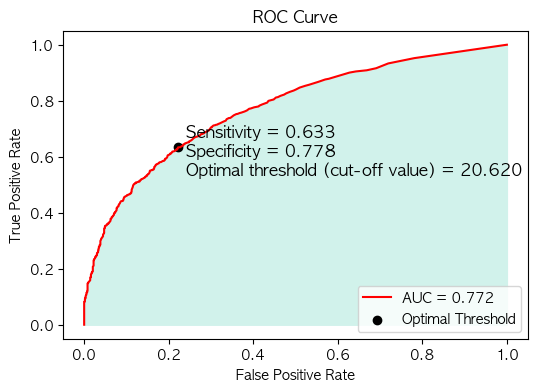

20.62

In [27]:
def create_and_save_roc_plot(data, variable_name, outcome):

    y_true = data[outcome].values
    y_scores = data[variable_name].values
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # 최적의 임계값 찾기
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    sensitivity = tpr[optimal_idx]
    specificity = 1 - fpr[optimal_idx]
    
    # 그래프 그리기
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='red', label=f'AUC = {roc_auc:.3f}')
    plt.fill_between(fpr, tpr, color="#D1F2EB")
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal Threshold')
    plt.text(fpr[optimal_idx] + 0.02, tpr[optimal_idx] - 0.1, f'Sensitivity = {sensitivity:.3f}\nSpecificity = {specificity:.3f}\nOptimal threshold (cut-off value) = {optimal_threshold:.3f}', fontsize=12)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    return optimal_threshold

create_and_save_roc_plot(data_filtered_both, 'score', 'outcome')

Accuracy: 0.6998784933171325

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.47      0.52       281
           1       0.75      0.82      0.78       542

    accuracy                           0.70       823
   macro avg       0.66      0.65      0.65       823
weighted avg       0.69      0.70      0.69       823



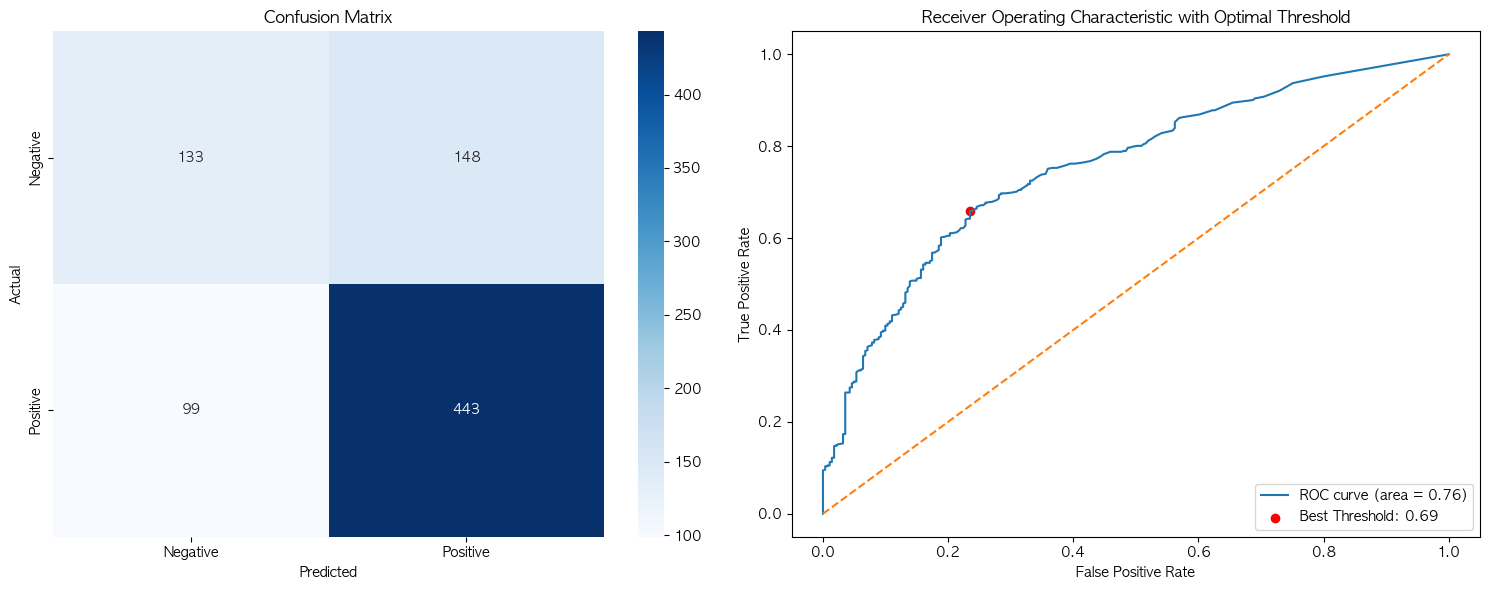

In [28]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]  # 예측 확률

# accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

# confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# 최적의 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# graph
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title('Confusion Matrix')

# ROC graph
ax[1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
ax[1].plot([0, 1], [0, 1], linestyle='--')  # 참조선
ax[1].scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Best Threshold: {optimal_threshold:.2f}')  # 최적의 임계값 표시
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic with Optimal Threshold')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [ ]:
# 예측값 별로 그래프 나누기 

plt.figure(figsize=(12, 6))
sns.scatterplot(data=X_test, x='day_cnt', y='avg_cnt', hue=y_pred, palette='viridis', alpha=0.7)

plt.xlabel('day_cnt')
plt.ylabel('avg_cnt')
plt.title('Scatter plot of avg_cnt and day_cnt colored by Predictions')
plt.legend(title='Prediction')
plt.show()


In [ ]:
X_test_0 = X_test[y_pred == 0]
X_test_1 = X_test[y_pred == 1]

plt.figure(figsize=(12, 6))

sns.kdeplot(data=X_test_0, x='day_cnt', y='avg_cnt', cmap='Blues', shade=True, label='Predicted: 0', alpha=0.5)
sns.kdeplot(data=X_test_1, x='day_cnt', y='avg_cnt', cmap='Oranges', shade=True, label='Predicted: 1', alpha=0.5)

plt.xlabel('day_cnt')
plt.ylabel('avg_cnt')
plt.title('Density plot of avg_cnt and day_cnt by Prediction')
plt.legend()
plt.show()
